## Set up working environment for tensorflow

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import Sequential, Model, Input, utils
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorboard import program
import matplotlib.pyplot as plt
import numpy as np
import datetime
import random
import os

In [2]:
def config_gpu():
    #Configure Gpus
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

In [3]:
config_gpu()

1 Physical GPUs, 1 Logical GPUs


## Tensorboard monitoring

In [4]:
tb = program.TensorBoard()
tb.configure(argv=[None, '--logdir', "."])
url = tb.launch()
print("Tensorboard url: ", url)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

Tensorboard url:  http://localhost:6006/


## Reading in data 

In [5]:
# Create a tensorflow pipeline

list_ds = tf.data.Dataset.list_files('Data/*/*')

# The files in each class directory are examples, list 10 of them
for f in list_ds.take(5):
    filename = f.numpy().decode('ascii')
    print(filename)

Data\DRUNSEN\DRUSEN-228939-61.jpeg
Data\NORMAL\NORMAL-495863-13.jpeg
Data\NORMAL\NORMAL-465734-6.jpeg
Data\NORMAL\NORMAL-122878-8.jpeg
Data\DRUNSEN\DRUSEN-2097208-3.jpeg


In [6]:
# print the length of entire dataset
DATA_LENGTH = tf.data.experimental.cardinality(list_ds).numpy() # len(list(list_ds)) is not efficient
print(f"Data length: {DATA_LENGTH}")

Data length: 10000


## Checkpoint 1: Define Training/Test data size and dimension. Explain the rationale for your selection.

In [7]:
TEST_SIZE = 0.25
IMG_SIZE = (64,64)
BATCH_SIZE = 32

print(f"Number of train samples: {(1 - TEST_SIZE) * DATA_LENGTH}")
print(f"Number of test samples: {TEST_SIZE * DATA_LENGTH}")
print(f"Resized Image dimension: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Input model shape: {(BATCH_SIZE, *IMG_SIZE, 1)}") # grayscale image only has 1 channel

Number of train samples: 7500.0
Number of test samples: 2500.0
Resized Image dimension: (64, 64)
Batch size: 32
Input model shape: (32, 64, 64, 1)


The dataset consists of 10,000 images which is a sizeable amount. Based on online searches, 75-25 train-test split is commonly used. I do not want to set a higher ratio for test set because it means longer training time and less test images for validation. Setting `TEST_SIZE = 0.25` is reasonable.

I set `img_size=(64,64)` as the images have different dimensions, and they all have to be reshaped to a fixed dimension before being fed into the model. The value is chosen to be smaller than the original image to reduce the intensive computation time (e.g. due to convolution) on my local machine, but big enough for a good resolution such that the overall accuracy is not compromised.

## Encoding labels as integers

In [8]:
def get_label_dict(path):
    # returns a dictionary with label as key, and idx as value
    label_dict = {}
    for idx, label in enumerate(os.listdir(path)):
        label_dict[label] = idx
    return label_dict

def label2idx(label):
    # converts string label to integer index
    return label_dict[label]

In [9]:
label_dict = get_label_dict('Data')

label_dict

{'CNV': 0, 'DME': 1, 'DRUNSEN': 2, 'NORMAL': 3}

## Preprocessing Images Functions 

In [10]:
def tensor_str2int(text):
    # converts tensor string eagerly and converts to integer index
    idx = label2idx(text.numpy().decode('ascii'))
    return tf.constant(idx, dtype='int32')

def process_path(file_path):
    # read in the raw features and the label
    img_bytes = tf.io.read_file(file_path)
    label_str = tf.strings.split(file_path, os.sep)[-2]
    
    # prepare img as input x
    img_decoded = tf.image.decode_jpeg(img_bytes) # decode using jpeg format
    img_scaled = tf.image.convert_image_dtype(img_decoded, tf.float32) # convert to float values in [0,1]
    img_resized = tf.image.resize(img_scaled, IMG_SIZE) # resize to a specific size
    
    # prepare label as input y
    label_int = tf.py_function(tensor_str2int, [label_str], tf.int32)
    
    return img_resized, label_int

def data_augmentation(img, label):    
    # horizontally flips the image with probability 1/2
    img = tf.image.random_flip_left_right(img)

    # slightly translates image in x and y direction
    img = tfa.image.translate(img, [random.randint(-5,5), random.randint(-5,5)])
    
    # make sure the image is still in [0, 1]
    img = tf.clip_by_value(img, 0.0, 1.0)

    return img, label

In [11]:
# prepare the dataset in the form of X,y
dataset = list_ds.map(process_path)

## Checkpoint 2: Print a sample of the data. Explain the selected range and the purpose of normalisation.

Normalization changes the range of pixel intensity values from [0, 255] to [0, 1], which is preferred for neural networks so that the linear combination for weight calculation is more controlled.

x is: [[[1.        ]
  [1.        ]
  [1.        ]
  ...
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  ...
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  ...
  [0.99828434]
  [0.9997549 ]
  [0.9936275 ]]

 ...

 [[0.09509805]
  [0.0257353 ]
  [0.08946079]
  ...
  [0.10294119]
  [0.08063726]
  [0.07328431]]

 [[0.00686274]
  [0.05465687]
  [0.06740196]
  ...
  [0.05759804]
  [0.07401961]
  [0.05931373]]

 [[0.05318628]
  [0.07426471]
  [0.0762255 ]
  ...
  [0.08504902]
  [0.01642157]
  [0.0504902 ]]]
y is: 2


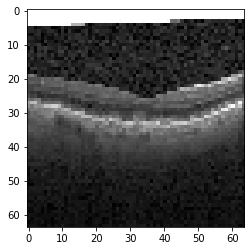

In [12]:
# print a sample of the data
for x,y in dataset.take(1):
    print("x is: {}".format(x))
    print("y is: {}".format(y))
    plt.imshow(x, cmap='gray')

## Build Base Model 

In [13]:
class MyModel(Model):
    def __init__(self, dim):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(32, 3, padding='same', activation='relu')
        self.pool = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')
        self.flatten = Flatten()
        self.d1 = Dense(256, activation='relu')
        self.d2 = Dense(128, activation='relu')
        self.d3 = Dense(4, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        return x
    
    def build_graph(self):
        x = Input(shape=(dim))
        return Model(inputs=[x], outputs=self.call(x))

In [14]:
dim = (*IMG_SIZE, 1) # img is grayscale, so only 1 channel
cnn_model = MyModel(dim)
cnn_model.build((BATCH_SIZE, *dim))

## Checkpoint 3: Display the graph. Print out of the model.

In [15]:
cnn_model.build_graph().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516   

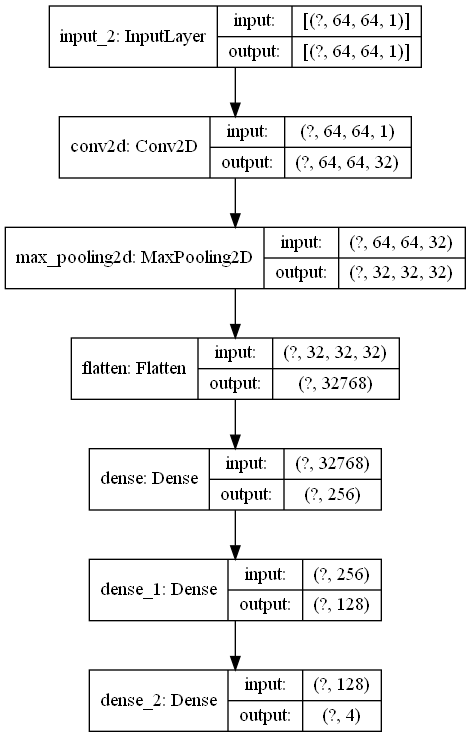

In [16]:
utils.plot_model(cnn_model.build_graph(), to_file='cnn_model.png', show_shapes=True)

## Checkpoint 4: Explain selection of loss function and optimiser Optimizer 

In [17]:
# Define Loss function and Optimiser

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

I use SparseCategoricalCrossentropy loss function because there are two or more label classes. Also, I will be encoding the labels as integers (as opposed to using CategoricalCrossEntropy using one-hot representation).

I use Adam due to its ability to leverage the power of adaptive learning rates methods to find individual learning rates for each parameter. Specifically, it uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum. As the algorithm combines the advantages of several other optimizers, choosing Adam therefore sounds like a reasonable approach to begin with.

## Metrics to measure the loss and the accuracy of the model

In [18]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

## Define Training/Testing Function

In [19]:
def train_step(model, optimizer, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)

def test_step(model, images, labels):
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)
    
    test_loss(t_loss)
    test_accuracy(labels, predictions)

## Split the dataset and train my own model 

In [20]:
# Split the dataset
dataset = dataset.shuffle(DATA_LENGTH)

train_ds = dataset.take(round(DATA_LENGTH * TEST_SIZE)).batch(BATCH_SIZE)
test_ds = dataset.skip(round(DATA_LENGTH * (1-TEST_SIZE))).batch(BATCH_SIZE)

In [21]:
def run_model(model, train_ds, test_ds, epochs):
    train_loss_hist = []
    train_acc_hist = []
    test_loss_hist = []
    test_acc_hist = []

    for epoch in range(epochs):
        for images, labels in train_ds:
            train_step(model, optimizer, images, labels)
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

        for test_images, test_labels in test_ds:
            test_step(model, test_images, test_labels)
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)

        # for plotting
        train_loss_hist.append(train_loss.result())
        train_acc_hist.append(train_accuracy.result())
        test_loss_hist.append(test_loss.result())
        test_acc_hist.append(test_accuracy.result())

        # print the results
        template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
        print(template.format(epoch+1,
                            train_loss.result(),
                            train_accuracy.result()*100,
                            test_loss.result(),
                            test_accuracy.result()*100))

        # Reset the metrics for the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()
        
    return train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist

In [22]:
EPOCHS = 20
train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist = run_model(cnn_model, train_ds, test_ds, epochs=EPOCHS)

Epoch 1, Loss: 1.3312546014785767, Accuracy: 35.52000045776367, Test Loss: 1.24891996383667, Test Accuracy: 40.63999938964844
Epoch 2, Loss: 1.2139909267425537, Accuracy: 43.279998779296875, Test Loss: 1.1472874879837036, Test Accuracy: 48.599998474121094
Epoch 3, Loss: 1.0913920402526855, Accuracy: 49.84000015258789, Test Loss: 1.0053552389144897, Test Accuracy: 55.44000244140625
Epoch 4, Loss: 0.9673362374305725, Accuracy: 58.15999984741211, Test Loss: 1.0272754430770874, Test Accuracy: 54.63999938964844
Epoch 5, Loss: 0.904592752456665, Accuracy: 60.79999923706055, Test Loss: 0.7747424840927124, Test Accuracy: 68.63999938964844
Epoch 6, Loss: 0.7827908396720886, Accuracy: 67.23999786376953, Test Loss: 0.9502905607223511, Test Accuracy: 58.63999557495117
Epoch 7, Loss: 0.7080382108688354, Accuracy: 71.04000091552734, Test Loss: 0.6402221918106079, Test Accuracy: 75.72000122070312
Epoch 8, Loss: 0.6055763959884644, Accuracy: 77.12000274658203, Test Loss: 0.5575211644172668, Test Accur

## Checkpoint 5: Display loss-epoch graph

In [23]:
def plot_loss_epoch_graph(train_loss_hist, test_loss_hist, epochs):
    plt.plot(range(epochs), train_loss_hist, 'g', label='Training loss')
    plt.plot(range(epochs), test_loss_hist, 'b', label='Test loss')
    plt.title('Training and Test loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

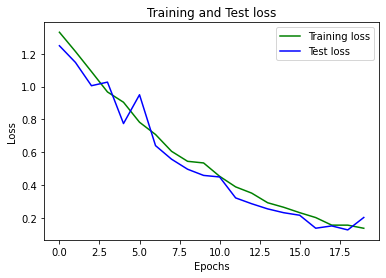

In [24]:
plot_loss_epoch_graph(train_loss_hist, test_loss_hist, EPOCHS)

There are no anomalies. The training and test loss values are in sync across epochs and decreasing steadily, slowly saturating near 0.

## Checkpoint 6: Display Accuracy-epoch graph

In [25]:
def plot_acc_epoch_graph(train_acc_hist, test_acc_hist, epochs):
    plt.plot(range(epochs), train_acc_hist, 'g', label='Training acc')
    plt.plot(range(epochs), test_acc_hist, 'b', label='Test acc')
    plt.title('Training and Test acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

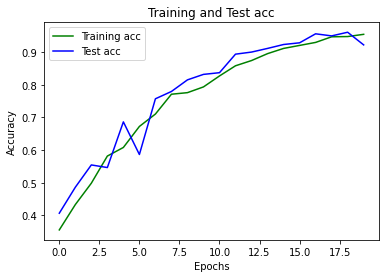

In [26]:
plot_acc_epoch_graph(train_acc_hist, test_acc_hist, EPOCHS)

There are no anomalies. The training and test accuracy values are in sync across epochs and increasing in a characteristic log shape that saturates near 1.

## Checkpoint 7: Define and explain the choice of transfer base model for transfer learning

I will be trying out two different base models: VGG19 and ResNet50.

VGG19 is a variant of VGG model which in short consists of 19 layers (16 convolution layers, 3 Fully connected layer, 5 MaxPool layers and 1 SoftMax layer). There are other variants of VGG like VGG11, VGG16 and others. VGG19 has 19.6 billion FLOPs. I intentionally chose VGG19 model because it has significantly more layers and trainable parameters, so I wanted to see if deeper layers in VGG19 would translate into better performance.

ResNet50 is a variant of ResNet model which has 48 Convolution layers along with 1 MaxPool and 1 Average Pool layer. It has 3.8 x 10^9 floating points operations. Because ResNet has skip connections, it is possible to train ultra deep neural networks, resolving identity mapping and vanishing gradient problems faced in very deep CNNs. Hence, I wanted to test if ResNet50 will indeed have equal or better performance than our own CNN model as well as the VGG19 model.

In [27]:
class TransferLearningModel(Model):
    def __init__(self, model, dim):
        super(TransferLearningModel, self).__init__()
        self.dim = dim
        self.base = model(include_top=False, weights='imagenet')
        self.base.trainable = False # freeze the model parameters
        self.gap = GlobalAveragePooling2D()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(256, activation='relu')
        self.d3 = Dense(4, activation='softmax')
    
    def call(self, x):
        # base model requires 3 channels, but our grayscale img only has 1 channel
        x = tf.tile(x, tf.constant([1,1,1,3], tf.int32))
        x = self.base(x)
        x = self.gap(x)
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        return x
    
    def build_graph(self):
        x = Input(shape=(self.dim))
        return Model(inputs=[x], outputs=self.call(x))

In [28]:
# VGG19 model
vgg_model = TransferLearningModel(VGG19, dim)
vgg_model.build((BATCH_SIZE, *dim))

In [29]:
# ResNet50 model
resnet_model = TransferLearningModel(ResNet50, dim)
resnet_model.build((BATCH_SIZE, *dim))

## Checkpoint 8: Display graph printout of the base model with the OCT image classication extension

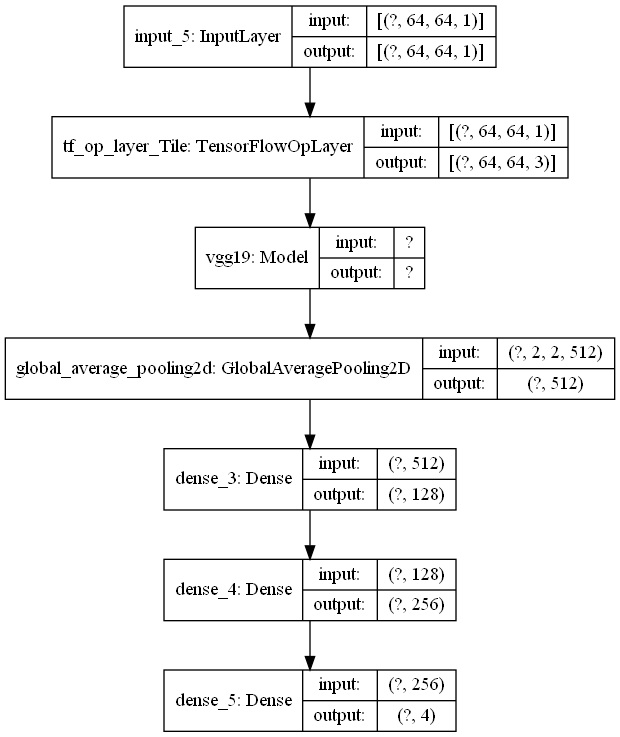

In [30]:
# VGG19 model architecture
utils.plot_model(vgg_model.build_graph(), to_file='vgg_model.png', show_shapes=True)

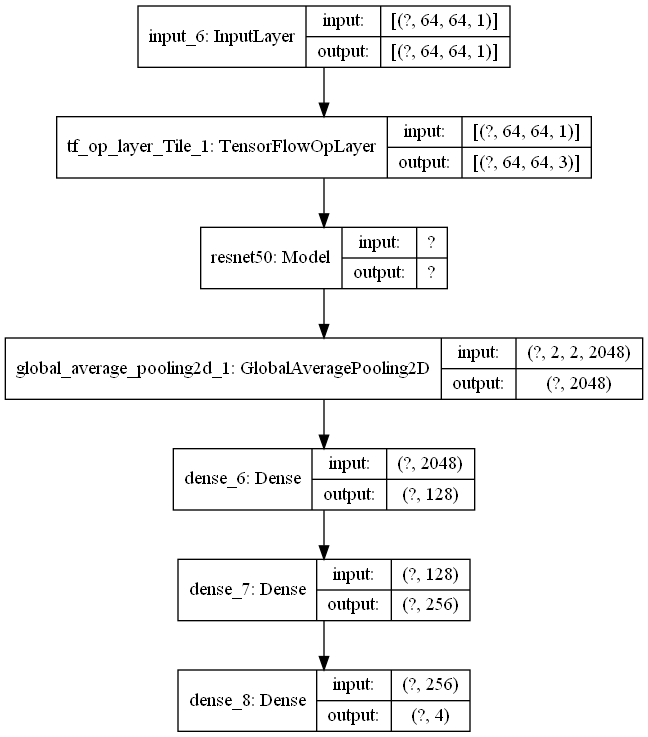

In [31]:
# ResNet50 model architecture
utils.plot_model(resnet_model.build_graph(), to_file='resnet_model.png', show_shapes=True)

## Train the VGG19 model

In [32]:
EPOCHS = 20
vgg_train_loss_hist, vgg_train_acc_hist, vgg_test_loss_hist, vgg_test_acc_hist = run_model(vgg_model, train_ds, test_ds, epochs=EPOCHS)

Epoch 1, Loss: 1.263519287109375, Accuracy: 40.52000045776367, Test Loss: 1.1841707229614258, Test Accuracy: 42.15999984741211
Epoch 2, Loss: 1.1526950597763062, Accuracy: 46.560001373291016, Test Loss: 1.1249696016311646, Test Accuracy: 49.15999984741211
Epoch 3, Loss: 1.0903514623641968, Accuracy: 50.12000274658203, Test Loss: 1.0577459335327148, Test Accuracy: 50.599998474121094
Epoch 4, Loss: 1.0432246923446655, Accuracy: 53.880001068115234, Test Loss: 1.0368214845657349, Test Accuracy: 52.03999710083008
Epoch 5, Loss: 1.0189694166183472, Accuracy: 54.47999954223633, Test Loss: 0.985905110836029, Test Accuracy: 56.36000061035156
Epoch 6, Loss: 0.9998964667320251, Accuracy: 53.439998626708984, Test Loss: 0.97013258934021, Test Accuracy: 58.60000228881836
Epoch 7, Loss: 0.9858682155609131, Accuracy: 55.87999725341797, Test Loss: 0.984603226184845, Test Accuracy: 55.959999084472656
Epoch 8, Loss: 0.9860013127326965, Accuracy: 55.959999084472656, Test Loss: 0.956098735332489, Test Accu

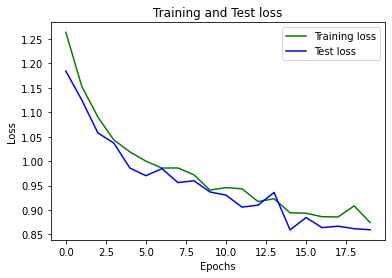

In [33]:
# loss-epoch graph
plot_loss_epoch_graph(vgg_train_loss_hist, vgg_test_loss_hist, EPOCHS)

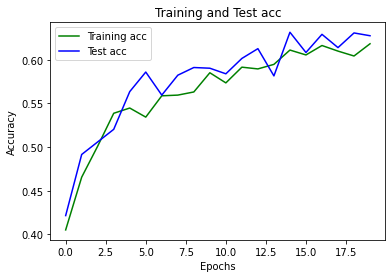

In [34]:
# accuracy-epoch graph
plot_acc_epoch_graph(vgg_train_acc_hist, vgg_test_acc_hist, EPOCHS)

## Train the ResNet50 model 

In [35]:
EPOCHS = 20
resnet_train_loss_hist, resnet_train_acc_hist, resnet_test_loss_hist, resnet_test_acc_hist = run_model(resnet_model, train_ds, test_ds, epochs=EPOCHS)

Epoch 1, Loss: 1.2729283571243286, Accuracy: 41.84000015258789, Test Loss: 1.3883821964263916, Test Accuracy: 26.760000228881836
Epoch 2, Loss: 1.125121831893921, Accuracy: 48.36000061035156, Test Loss: 1.378304123878479, Test Accuracy: 24.760000228881836
Epoch 3, Loss: 1.0417137145996094, Accuracy: 52.79999923706055, Test Loss: 1.3811291456222534, Test Accuracy: 30.000001907348633
Epoch 4, Loss: 1.038642168045044, Accuracy: 53.52000045776367, Test Loss: 1.4839441776275635, Test Accuracy: 30.079999923706055
Epoch 5, Loss: 1.0100452899932861, Accuracy: 56.12000274658203, Test Loss: 1.3869866132736206, Test Accuracy: 31.15999984741211
Epoch 6, Loss: 0.9621050953865051, Accuracy: 58.560001373291016, Test Loss: 1.4042259454727173, Test Accuracy: 30.959999084472656
Epoch 7, Loss: 0.9380584955215454, Accuracy: 58.79999923706055, Test Loss: 1.4504263401031494, Test Accuracy: 29.15999984741211
Epoch 8, Loss: 0.8899533152580261, Accuracy: 60.91999816894531, Test Loss: 1.5316017866134644, Test A

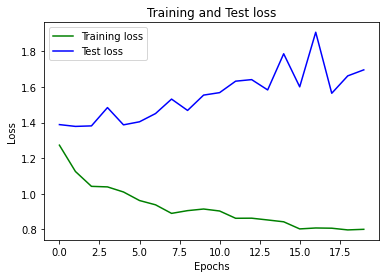

In [36]:
# loss-epoch graph
plot_loss_epoch_graph(resnet_train_loss_hist, resnet_test_loss_hist, EPOCHS)

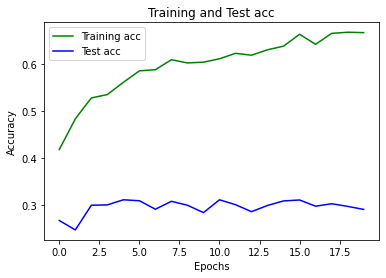

In [37]:
# accuracy-epoch graph
plot_acc_epoch_graph(resnet_train_acc_hist, resnet_test_acc_hist, EPOCHS)

## Checkpoint 9: Compare our own model and the transfer learning model
The training data currently being used is simple and as such transfer learning isn't as advantageous, however some observations can be made when comparing the first model with the second, discuss these observation.

### Our CNN model vs VGG19 model vs ResNet50 model

<u>Observation 1: Presence of overfitting</u>

Both our CNN model and the VGG19 model have the train loss/accuracy in sync with the test loss/accuracy across epochs, meaning that the models have not overfitted. 

However, for the ResNet50 model, the train loss decreased but the test loss increased across epochs. Also, the train accuracy increased but the test accuracy remained relatively unchanged. These observations indicate that the ResNet50 model has overfitted on the training data.

<u>Observation 2: Performance metrics</u>

Based on the performance scores, our CNN model performs significantly better than both the transfer learning models with lower loss and higher accuracy. In the case of VGG19 model, the suboptimal performance could be because when there are too many layers, the extracted features in the deeper layers are specific to the 1000 class images in the imagenet competition when we freeze the parameters in the base VGG19 model. In the case of ResNet50 model, the very poor performance was due to overfitting as discussed earlier.

A possible improvement would be to unfreeze the parameters for the deeper layers of the pretrained models, so that the learned parameters can learn the specific features of our custom dataset better.

<u>Observation 3: Training time</u>

For each training epoch, the VGG model takes much longer, because there are more trainable parameters that need to be updated in each epoch. That said, for the same number of epochs, our CNN model is able to converge more quickly and achieve lower loss and higher accuracy. This could be because the VGG19 model is more complex with more layers, so it could take a while trying to fine tune model parameters in the classifier layer when there really is no need for such higher-order dimensional feature representation for a simple classification task with only 4 classes. For the ResNet50 model, the training time is much faster, although the trained weights are not optimal.

## Checkpoint 10: Discuss why bias data may not be favourable and the problems it presents.
The training data provided is bias i.e. The class CNV has less representation that the other class.

Context: The class CNV only has 1000 images, while the other 3 classes (DME, DRUNSEN, NORMAL) each has 3000 images.

Firstly, the model will have significantly less features to learn from the fewer samples in the minority class CNV. Hence, when a similar CNV image is passed into the model, it might not be able to pick up the features and classify it correctly.

Secondly, as there are less samples in the class CNV, the model might be biased toward predicting the label of any test sample as one of the other 3 majority classes, so as to reduce the overall loss. This means that CNV test samples are more likely to be misclassified, possibly resulting in wrong diagnosis.

## Checkpoint 11: Show some methods that can be utilised to negate or minimise these effects.
Compare the accuracy and explain the pros and cons of these techniques (if any).

### Method 1: Data Augmentation
The data augmentation is defined above, which randomly flips the image horizontally and applies random small horizontal and verical translations to the original image. To make the number of samples equal in each class, we will augment another 2000 images from the CNV class to match the the number of images in DME/DRUNSEN/NORMAL class.

Pro: The model is able to extract more features with a larger sample size as well as a more diverse dataset for the minority class. This could help reduce overfitting.

Con: Image processing time will be increased as they have to be augmented. The training time will also increase due to a larger dataset.

In [38]:
dataset_aug = dataset
cnv_ds = tf.data.Dataset.list_files('Data/CNV/*').map(process_path)

# augment another 2000 images
for i in range(2):
    cnv_aug_ds = cnv_ds.map(lambda x, y: (data_augmentation(x, y)))
    dataset_aug = dataset_aug.concatenate(cnv_aug_ds)

# each class now should have 3000 images, so total should be 12000
AUG_DATA_LENGTH = tf.data.experimental.cardinality(dataset_aug).numpy()
print(f"Data length: {AUG_DATA_LENGTH}")

Data length: 12000


In [39]:
# Split the dataset
dataset_aug = dataset_aug.shuffle(AUG_DATA_LENGTH)

train_aug_ds = dataset_aug.take(round(AUG_DATA_LENGTH * TEST_SIZE)).batch(BATCH_SIZE)
test_aug_ds = dataset_aug.skip(round(AUG_DATA_LENGTH * (1-TEST_SIZE))).batch(BATCH_SIZE)

In [45]:
aug_cnn_model = MyModel(dim)
aug_cnn_model.build((BATCH_SIZE, *dim))

In [46]:
EPOCHS = 20
aug_train_loss_hist, aug_train_acc_hist, aug_test_loss_hist, aug_test_acc_hist = run_model(aug_cnn_model, train_aug_ds, test_aug_ds, epochs=EPOCHS)

Epoch 1, Loss: 0.8725698590278625, Accuracy: 62.75, Test Loss: 1.049699306488037, Test Accuracy: 48.36666488647461
Epoch 2, Loss: 0.9933366775512695, Accuracy: 53.79999923706055, Test Loss: 0.9628810286521912, Test Accuracy: 56.46666717529297
Epoch 3, Loss: 0.8893086910247803, Accuracy: 60.79999923706055, Test Loss: 0.876003086566925, Test Accuracy: 60.4666633605957
Epoch 4, Loss: 0.8302165269851685, Accuracy: 64.80000305175781, Test Loss: 0.7446414232254028, Test Accuracy: 69.13333892822266
Epoch 5, Loss: 0.7221137285232544, Accuracy: 69.70000457763672, Test Loss: 0.7011615037918091, Test Accuracy: 71.69999694824219
Epoch 6, Loss: 0.693373441696167, Accuracy: 70.76667022705078, Test Loss: 0.6133500933647156, Test Accuracy: 75.80000305175781
Epoch 7, Loss: 0.6037392020225525, Accuracy: 75.5999984741211, Test Loss: 0.5326475501060486, Test Accuracy: 79.06666564941406
Epoch 8, Loss: 0.5286175608634949, Accuracy: 79.0999984741211, Test Loss: 0.5046261548995972, Test Accuracy: 80.866661071

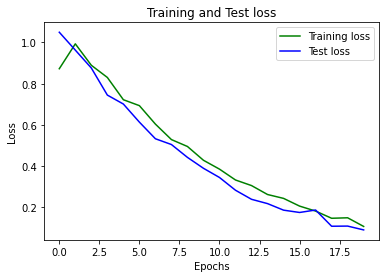

In [47]:
# loss-epoch graph
plot_loss_epoch_graph(aug_train_loss_hist, aug_test_loss_hist, EPOCHS)

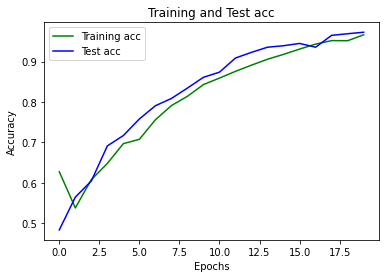

In [48]:
# accuracy-epoch graph
plot_acc_epoch_graph(aug_train_acc_hist, aug_test_acc_hist, EPOCHS)

With data augmentation, the train and test loss are lower at the end of the 20 epochs. The train and test accuracies are also higher. These results show that data augmentation can improve the model performance.

### Method 2: Weighted Class Averages 
Using weighted class average means that the influence of the minority classes will be scaled up proportionally when computing training loss or accuracy, as though every class is now represented by the same number of samples.

Pro: The training time should not increase.

Con: Each training sample from the minority class will influence the training loss and accuracy even more, so the model performance will be more heavily impacted in a negative way if some are of bad quality. 

This weighted class average method is likely worse than the earlier proposed method of data augmentation, which increase the diversity of the available images and help reduce overfitting.

## References used
1. https://www.tensorflow.org/guide/data
2. https://cs230.stanford.edu/blog/datapipeline/
3. https://stackoverflow.com/questions/61427583/how-do-i-plot-a-keras-tensorflow-subclassing-api-model
4. https://github.com/sambit9238/Deep-Learning/blob/master/mnist.py
5. https://iq.opengenus.org/vgg19-architecture/
6. https://iq.opengenus.org/resnet50-architecture/